# Model 1: Baseline 

This model will be built using **only** beatAML data to predict AUC. 




In [274]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import pickle
from torch.utils import data
from matplotlib import pyplot as plt
import pandas as pd

# Define our Dataset Class 

In [57]:
class DrugExpressionDataset(Dataset): 
    '''
    '''
    def __init__ (self, label_dict, root_dir='../data_pytorch/tensors'): 
        '''
        '''
        self.index = list(label_dict.keys())
        self.labels = label_dict
        self.root = root_dir
                            
    def __len__(self):
        '''
        '''
        return len(self.labels.keys())
        
    def __getitem__(self, index, response_type=False):
        '''
        '''
        fid = self.index[index]
        X = torch.load(f'{self.root}/{fid}.pt')
        _id, id_type, resp_type, response = self.labels[fid]
        
        if response_type: 
            return X, (response, resp_type)
        else: 
            return X, response

# Separate data into train/test/validate 

In [58]:
train, test, val = (0.7,0.15,0.15)

with open('../data_pytorch/label_dict.pkl', 'rb') as f: 
    label_dict = pickle.load(f)

label_dict2 = dict()
for fid in label_dict: 
    _id, id_type, resp_type, response = label_dict[fid]
    
    if resp_type not in label_dict2: 
        label_dict2[resp_type] = dict()
        
    p = np.random.rand()
    if (p < train): # add to training set 
        if 'train' in label_dict2[resp_type]: 
            label_dict2[resp_type]['train'][fid] = (_id, id_type, resp_type, response)
        else:
            label_dict2[resp_type]['train'] = {fid:(_id, id_type, resp_type, response)}

    elif (p < train+test): # add to test set 
        if 'test' in label_dict2[resp_type]: 
            label_dict2[resp_type]['test'][fid] = (_id, id_type, resp_type, response)
        else:
            label_dict2[resp_type]['test'] = {fid:(_id, id_type, resp_type, response)}
    else: # add to validation set 
        if 'val' in label_dict2[resp_type]: 
            label_dict2[resp_type]['val'][fid] = (_id, id_type, resp_type, response)
        else:
            label_dict2[resp_type]['val'] = {fid:(_id, id_type, resp_type, response)}            
    
    


In [59]:
label_dict2.keys()

dict_keys(['RNAi_dependency', 'crispr_dependency', 'pooled_drugresp_prism', 'AUC_GDSC', 'CTRP_AUC', 'AUC_drug_CCLE', 'beatAML_AUC'])

In [60]:
for resp_type in label_dict2:
    for sset in label_dict2[resp_type]: 
        pp = resp_type + ' '*(20 - len(resp_type))
        print(f'set sizes: {pp} \t-> {sset}  \t-> {len(label_dict2[resp_type][sset])}')

set sizes: RNAi_dependency      	-> test  	-> 46933
set sizes: RNAi_dependency      	-> train  	-> 217570
set sizes: RNAi_dependency      	-> val  	-> 46692
set sizes: crispr_dependency    	-> train  	-> 219409
set sizes: crispr_dependency    	-> test  	-> 46682
set sizes: crispr_dependency    	-> val  	-> 46885
set sizes: pooled_drugresp_prism 	-> val  	-> 23217
set sizes: pooled_drugresp_prism 	-> train  	-> 107985
set sizes: pooled_drugresp_prism 	-> test  	-> 22991
set sizes: AUC_GDSC             	-> test  	-> 3645
set sizes: AUC_GDSC             	-> train  	-> 16882
set sizes: AUC_GDSC             	-> val  	-> 3621
set sizes: CTRP_AUC             	-> train  	-> 19615
set sizes: CTRP_AUC             	-> test  	-> 4190
set sizes: CTRP_AUC             	-> val  	-> 4173
set sizes: AUC_drug_CCLE        	-> train  	-> 1667
set sizes: AUC_drug_CCLE        	-> val  	-> 371
set sizes: AUC_drug_CCLE        	-> test  	-> 342
set sizes: beatAML_AUC          	-> train  	-> 1824
set sizes: beat

# Defining our model architecture 

Going to use a straight forward 4 layer FFFC network. 

In [243]:
class Net(nn.Module):

    def __init__(self, ngenes, sz=(250,100), do=0.3, nconvs = 5):
        super(Net, self).__init__()
        
        H1, H2 = sz
        
        self.layer1 = nn.Sequential(nn.Conv2d(1, nconvs, kernel_size=(1,2), stride=1, padding=0),
                                   nn.ReLU())
        
        self.do1 = torch.nn.Dropout(do)
        self.fc1 = nn.Linear(ngenes*nconvs, H1)
        self.bn1 = nn.BatchNorm1d(H1)
        self.do2 = torch.nn.Dropout(do)
        self.fc2 = nn.Linear(H1, H2)
        self.bn2 = nn.BatchNorm1d(H2)
        self.out = nn.Linear(H2, 1)

    def forward(self, x):
        x=x.unsqueeze(1)
        z0 = self.layer1(x)
        z0 = z0.reshape(z0.size(0), -1)
        z1= self.fc1( z0 )
        z1 = self.do1( z1 )
        z1 = self.bn1( z1 )
        a1 = F.relu( z1 )
        z2 = self.do2( self.fc2(a1) )
        z2 = self.bn2( z2 )
        a2 = F.relu(z2)
        o = self.out(a2)
        
        return o

# Initialize our model and DataLoader(s)

In [290]:
LEARNING_WEIGHT = 1e-3
EPOCHS = 100
DECAY_MILESTONES = range(100, EPOCHS, 10)
GAMMA=0.1
DROP_OUT_PROP = 0.5
LAYER_SIZE= (100, 50) # 2 layers
WEIGHT_DECAY = 0.01

# Reproducibility
torch.manual_seed(2)
np.random.seed(2)

In [291]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [292]:
net = Net(ngenes = 523, sz=LAYER_SIZE, do=DROP_OUT_PROP)
print(net)

Net(
  (layer1): Sequential(
    (0): Conv2d(1, 5, kernel_size=(1, 2), stride=(1, 1))
    (1): ReLU()
  )
  (do1): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=2615, out_features=100, bias=True)
  (bn1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (do2): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (bn2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (out): Linear(in_features=50, out_features=1, bias=True)
)


In [293]:
# Parameters
params = {'batch_size': 128,
          'shuffle': True,
          'num_workers': 0}

train_set = DrugExpressionDataset(label_dict2['beatAML_AUC']['train'])
test_set = DrugExpressionDataset(label_dict2['beatAML_AUC']['test'])
val_set = DrugExpressionDataset(label_dict2['beatAML_AUC']['val'])

train_gen = data.DataLoader(train_set, **params)
test_gen = data.DataLoader(test_set, **params)
val_gen = data.DataLoader(val_set, **params)

In [294]:
optim = torch.optim.AdamW(net.parameters(recurse=True), lr=LEARNING_WEIGHT, weight_decay=WEIGHT_DECAY, amsgrad=True)
loss_func = torch.nn.MSELoss()
scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, milestones=DECAY_MILESTONES, gamma=GAMMA)

# Train our model

In [295]:
recorder={'train':{'total_loss':[], 'mse':[]}, 'val':{'mse':[]}}

for epoch in range(EPOCHS):
    total_loss = 0
    mse = 0
    for X,y in train_gen:
        X,y = X.to(device, dtype=torch.float), y.to(device, dtype=torch.float)
        y = y.unsqueeze(1)
        optim.zero_grad()
        yhat = net.forward(X)
        loss = loss_func(yhat, y)
        loss.backward()
        optim.step() 
        scheduler.step()
        total_loss += loss.detach().numpy()
        
    recorder['train']['total_loss'].append(total_loss)
    recorder['train']['mse'].append(total_loss/len(train_gen))

    val_total_loss = 0
    with torch.set_grad_enabled(False):
        for X, y in val_gen:
            X,y = X.to(device, dtype=torch.float), y.to(device, dtype=torch.float)
            y = y.unsqueeze(1)
            yhat = net.forward(X)
            val_total_loss += loss_func(yhat, y).detach().numpy()
        recorder['val']['mse'].append(val_total_loss / len(val_gen))
        
    print(f'epoch {epoch+1}/{EPOCHS} \t|\t train total loss: {int(total_loss)} \t train mse: {int(total_loss/len(train_gen))} \t|\t val mse: {int(val_total_loss / len(val_gen))} \t\t\t', end='\r')

### visualize training 

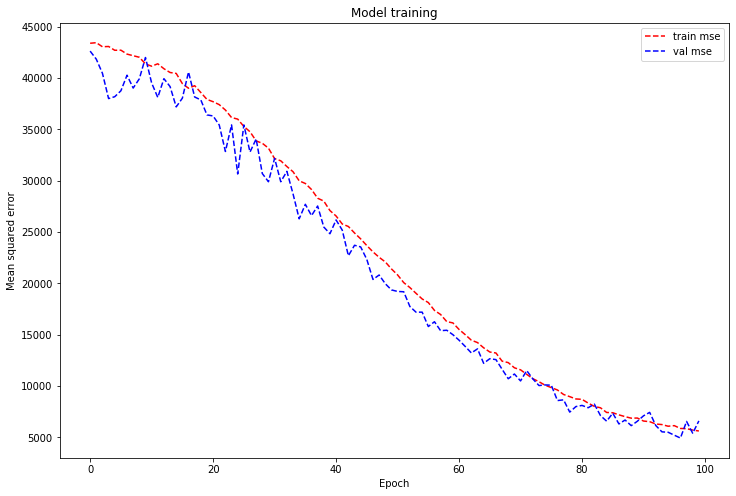

In [296]:
plt.figure(figsize=(12,8))
plt.plot(recorder['train']['mse'], 'r--', label='train mse')
plt.plot(recorder['val']['mse'], 'b--', label='val mse')
plt.xlabel('Epoch')
plt.ylabel('Mean squared error')
plt.title('Model training')
plt.legend()
plt.show()

# Test our model
WHY IS THIS GIVING SLIGHTLY DIFFERENT VALUES 

In [297]:
net.eval()
test_total_loss = 0
yhats = []
ys = []
for X, y in test_gen:
    X,y = X.to(device, dtype=torch.float), y.to(device, dtype=torch.float)
    y = y.unsqueeze(1)
    yhat = net.forward(X)
    test_total_loss += loss_func(yhat, y).detach().numpy()
    yhats += yhat.detach().numpy().ravel().tolist()
    ys += y.detach().numpy().ravel().tolist()

net.train()

print(f'test mse: {test_total_loss/len(test_gen)}')

test mse: 10368.15380859375


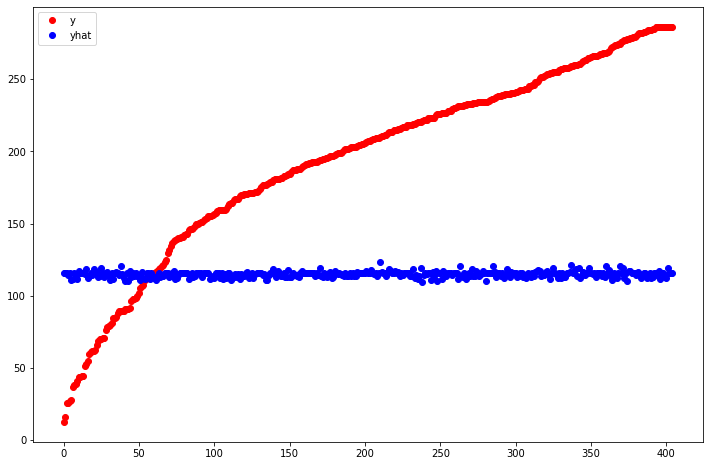

In [298]:
df = pd.DataFrame({'y':ys, 'yhat':yhats})
df.sort_values(by='y', inplace=True)

plt.figure(figsize=(12,8))
plt.plot(df.values[:,0], 'ro', label='y')
plt.plot(df.values[:,1], 'bo', label='yhat')
plt.legend()
plt.show()
